In [1]:
import threading
import mido

import loader as ml
import scheduler as mp

## helper functions

In [2]:
def show_tree(tree, total_width=60, fill=" "):
    import math
    from io import StringIO

    output = StringIO()
    last_row = -1
    for i, n in enumerate(tree):
        if i:
            row = int(math.floor(math.log(i + 1, 2)))
            if row > 3:
                break
        else:
            row = 0
        if row != last_row:
            output.write("\n")
        columns = 2**row
        col_width = int(math.floor((total_width * 1.0) / columns))
        output.write(str(f"{n[1].global_ticks:02d}").center(col_width, fill))
        last_row = row
    print(output.getvalue())
    print("-" * total_width)
    return

In [3]:
def save_queue_to_midi(scheduler, output_filename):
    from mido import MidiTrack, MidiFile

    """Reads the event queue from the scheduler and saves it as a MIDI file."""
    # Create a new MIDI file and a single track
    midi = MidiFile()
    track = MidiTrack()
    meta_track = MidiTrack()
    meta_track.append(mido.MetaMessage("set_tempo", tempo=scheduler.tempo, time=0))
    meta_track.append(
        mido.MetaMessage(
            "time_signature",
            numerator=4,
            denominator=4,
            clocks_per_click=24,
            notated_32nd_notes_per_beat=8,
            time=0,
        )
    )
    meta_track.append(mido.MetaMessage("end_of_track", time=1))
    midi.tracks.append(meta_track)
    track.append(mido.Message("program_change", channel=0, program=0, time=0))
    midi.tracks.append(track)
    last_event_ticks = 0

    # Sort the queue to ensure events are in the correct order
    with scheduler.queue_lock:
        sorted_events = sorted(scheduler.event_queue)

    for event_ticks, midi_event in sorted_events:
        ticks_delta = event_ticks - last_event_ticks
        last_event_ticks = event_ticks

        # Create a new message with the correct time delta
        event_data = midi_event.msg.copy(time=ticks_delta)
        track.append(event_data)

    # Save the MIDI file
    midi.save(output_filename)
    print(f"MIDI file saved as {output_filename}")

## run

In [4]:
bpm = 60

print(f"segment separation will be {8 * (60 / bpm)} seconds")

loader = ml.Loader("data/datasets/test/synthetic", bpm)
loader.load_midi_files()

scheduler = mp.Scheduler(bpm)
scheduler.start_playback()


# schedule the files in a separate thread
def scheduling_thread():
    start_ticks = mido.second2tick(3.0, loader.ticks_per_beat, mido.bpm2tempo(bpm))
    for midi_file in loader.midi_files:
        scheduler.schedule_events(midi_file, start_ticks)
        start_ticks += loader.duration_t - loader.ticks_per_beat
    save_queue_to_midi(scheduler, "outputs/output.mid")
    show_tree(scheduler.event_queue)


threading.Thread(target=scheduling_thread, name="scheduler").start()

segment separation will be 8.0 seconds
segments have 96 tpb and duration 864 ticks
loaded 10 files
scheduling baba-060-02_0005-0011	at 003.000s (288 ticks)
sleeping for 3.95 seconds (4.00s - 0.05s)
scheduling bbbb-060-01_0005-0011	at 011.000s (1056 ticks)
scheduling c4v100-060-03_0000-0005	at 019.000s (1824 ticks)
scheduling c4v97-060-03_0005-0011	at 027.000s (2592 ticks)
scheduling cascas-060-02_0000-0005	at 035.000s (3360 ticks)
scheduling cascd-060-02_0000-0005	at 043.000s (4128 ticks)


scheduling cascd-060-02_0005-0011	at 051.000s (4896 ticks)
scheduling cccc-060-01_0000-0005	at 059.000s (5664 ticks)
scheduling leadtest-060-03_0000-0005	at 067.000s (6432 ticks)
scheduling trailtest-060-03_0005-0011	at 075.000s (7200 ticks)
MIDI file saved as outputs/output.mid

                            264                             
             288                           456              
      480            648            672            840      
   96    264    288    456    480    648    672    840  
------------------------------------------------------------
sleeping for 1.75 seconds (5.75s - 4.00s)
sleeping for 0.25 seconds (6.00s - 5.75s)
sleeping for 1.74 seconds (7.75s - 6.01s)
sleeping for 0.24 seconds (8.00s - 7.76s)
sleeping for 1.74 seconds (9.75s - 8.01s)
sleeping for 0.24 seconds (10.00s - 9.76s)
sleeping for 1.75 seconds (11.75s - 10.00s)
sleeping for 0.25 seconds (12.00s - 11.75s)
sleeping for 1.74 seconds (13.75s - 12.01s)
sleeping for 0.24 seconds (14.00s

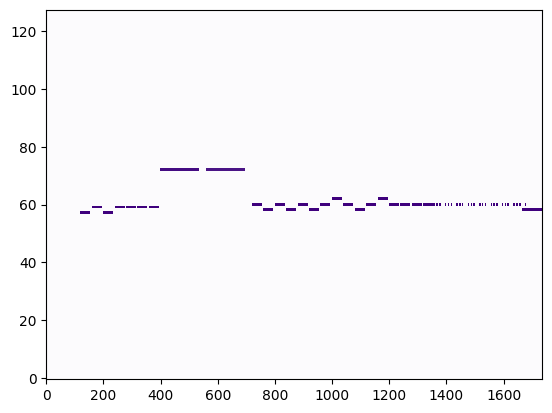

In [5]:
from matplotlib import pyplot as plt
import pretty_midi

pr = pretty_midi.PrettyMIDI("outputs/output.mid").get_piano_roll()

plt.imshow(pr, aspect="auto", origin="lower", cmap="Purples", interpolation="nearest")
plt.show()

In [6]:
file = mido.MidiFile("outputs/output.mid")
file.print_tracks()
with mido.open_output("Disklavier") as outport:
    for msg in file.play():
        if not msg.is_meta:
            outport.send(msg)

=== Track 0
MetaMessage('set_tempo', tempo=1000000, time=0)
Message('note_off', channel=0, note=59, velocity=64, time=552)
Message('note_on', channel=0, note=57, velocity=104, time=24)
Message('note_off', channel=0, note=57, velocity=64, time=168)
Message('note_on', channel=0, note=59, velocity=104, time=24)
Message('note_off', channel=0, note=59, velocity=64, time=168)
Message('note_on', channel=0, note=57, velocity=104, time=24)
Message('note_off', channel=0, note=57, velocity=64, time=168)
Message('note_on', channel=0, note=59, velocity=104, time=24)
Message('note_off', channel=0, note=59, velocity=64, time=168)
Message('note_on', channel=0, note=59, velocity=104, time=24)
Message('note_off', channel=0, note=59, velocity=64, time=168)
Message('note_on', channel=0, note=59, velocity=104, time=24)
Message('note_off', channel=0, note=59, velocity=64, time=168)
Message('note_on', channel=0, note=59, velocity=104, time=24)
Message('note_off', channel=0, note=59, velocity=64, time=168)
Me